## DVS Training Session 1

Introductory training using the Dish Verification System.

Essential reference: [DVS Operations Guide](https://docs.google.com/document/d/1mcpPv016eiNRHrLvt-Uu9z1ZOJPM4-2BknOOIALipIc)

                                                                        as of 4/06/2024

In [1]:
%pylab inline

# SARAO standard frameworks
import katpoint, katdal
import logging; logging.disable(logging.DEBUG) # Otherwise katdal is unbearable

# DVS-specific frameworks
import sys; sys.path.append('/home/aph/work/dvs')
from dvs import planning, fastgain
from systemsanalysis import katselib, katsepnt, fit_pointing_model

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/aph/work/dvs/libraries/systemsanalysis/katsemodels.py:1116: RuntimeWarning: divide by zero encountered in divide
  I_therm = lambda p, f_MHz: p[0] * (f_MHz/p[1])**2 * (1 - np.exp(-(f_MHz/p[1])**-2)) # The radiation intensity of a nebula in thermal equilibruim... Opacity tau(f)=(f/p[1])^2 fits the data.
/home/aph/work/dvs/libraries/systemsanalysis/katsemodels.py:1116: RuntimeWarning: invalid value encountered in multiply
  I_therm = lambda p, f_MHz: p[0] * (f_MHz/p[1])**2 * (1 - np.exp(-(f_MHz/p[1])**-2)) # The radiation intensity of a nebula in thermal equilibruim... Opacity tau(f)=(f/p[1])^2 fits the data.


INFO: Orion A (thermal) flux model fitted coefficients: [ 398.80529653 -437.57217069]
INFO: Orion A (power law) flux model fitted coefficients: [-0.84961654  1.87011783 -0.24937387]


## Planning

In [2]:
## Some available catalogues:
!ls ../catalogues

arrays	      sources_all.csv	  targets_pnt_L.csv
rfi_mask.txt  targets_pnt_Ku.csv  targets_pnt_S.csv


Targets visible from antenna 'A0' at 2024-06-04 13:37:12.532 SAST, with flux density (Jy) evaluated at 1400 MHz

Target                        Azimuth    Elevation <    Flux Fringe period
------                        -------    --------- -    ---- -------------
Zenith                      0:00:00.0   90:00:00.0 -        
J0522-3627               -132:09:20.9   81:05:34.5 \        
J0519-4546               -157:28:24.4   73:23:52.0 \    66.6
J0440-4333               -135:46:46.4   70:19:07.0 \        
J0535-0523                -11:35:28.6   64:13:26.0 \   364.1
J0752-2625                 87:57:27.1   64:06:06.0 /    11.9
J0627-0553                 18:18:57.8   64:05:29.4 /        
J0541-0153                 -7:04:06.6   60:59:30.3 \    52.2
J0824-4259                123:19:30.0   58:11:23.5 /    18.2
J0322-3712               -111:57:32.9   57:50:29.5 \   125.0
J0833-4543                127:39:08.0   56:00:17.8 /   238.2
J0835-4510                126:34:24.6   55:48:19.1 /        
J0859

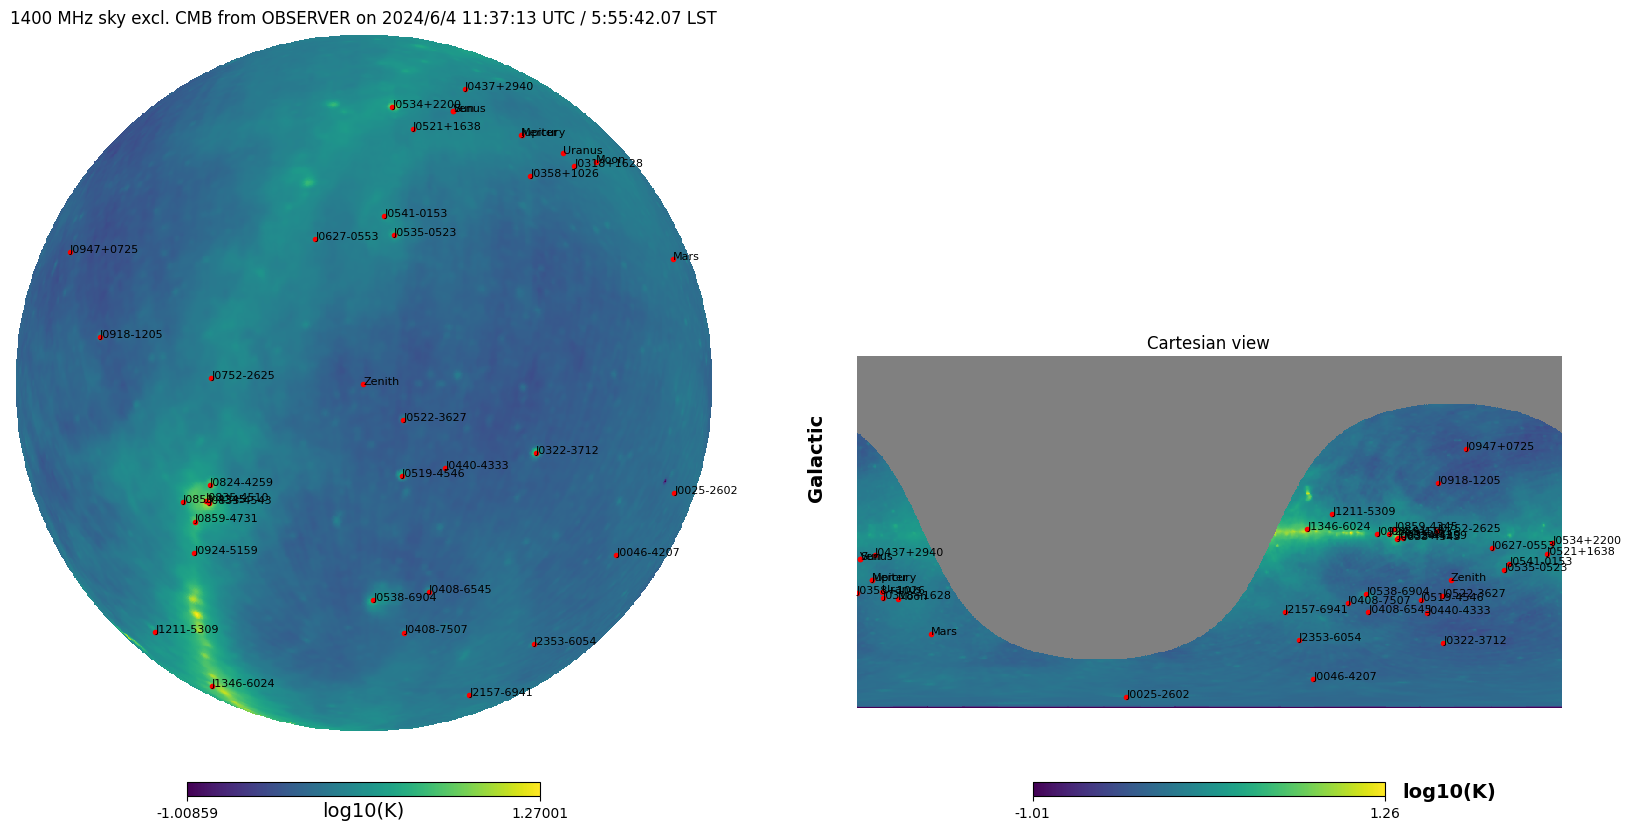

In [4]:
Tobs = katpoint.Timestamp().secs # or e.g. (2021,5,1, 6,0,0)
cat = planning.radiosky(Tobs, f_MHz=1400, catfn="../catalogues/sources_all.csv", el_limit_deg=10)

Target [J1745-2900 (Sgr A, S] as observed by [m000] on 2024/6/4 11:37:13, at 1000 MHz
--------------------------------------------------------------------------------
Delay rate -1.43107e-12 [sec/sec].
  At observed frequency: delay rate -0.52 [deg/sec], fringe period -698.78 [sec]
Rises above 20 degEl at 2024/6/3 17:59:20 UTC (sidereal 12:15:49.94)
Sets below 20 degEl at 2024/6/5 04:56:25 UTC (sidereal 23:18:38.79)
Flux 467.74 Jy


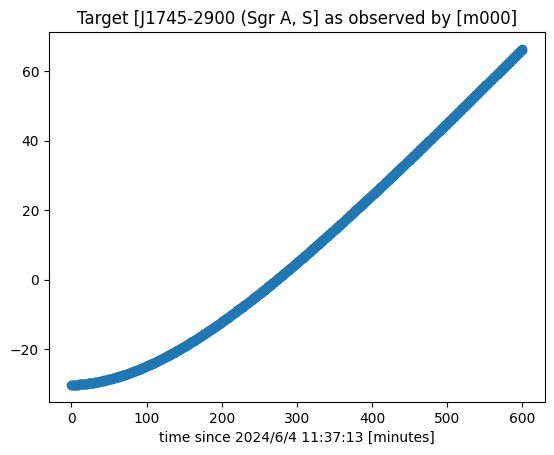

In [5]:
tgt = planning.describe_target("J1745-2900", catfn="../catalogues/sources_all.csv", horizon_deg=20,
                               baseline_pt=(4,130,0), date=Tobs, end_date=Tobs+10*60*60) # or e.g. (2021,5,1, 6,0,0)

## Observation - Manual Control
More info at [DVS Operations Guide](https://docs.google.com/document/d/1mcpPv016eiNRHrLvt-Uu9z1ZOJPM4-2BknOOIALipIc).

Open the signal displays and configure it to show spectrum & time-scrolling power & phase. Refer to the [Signal Display Manual](https://docs.google.com/document/d/1EdlZ2Wq4DLJs1QJZU0ktxODE8OO52fckyeeViDc5Yqc/edit).

Log on to obs.*???*.karoo.kat.ac.za and proceed with:
    
    ipython
    
    import katuilib
    configure_cam("all")
    
    cam.ants.req.target( cam.sources["J1745-2900"].description )
    cam.ants.req.mode("POINT")
    # At this point digitiser data & sensors are up & sensible
    
    cam.sdp.req.capture_init() # Prepare signal ingest & displays
    cam.cbf.req.capture_start()
    
    # Now F & X-engine data & sensors are valid, displays & ingest get valid data

Do some manual things and see how it plays out in the signal displays:

    cam.print_status("m049")
    
    cam.ants.req.dig_attenuation("h", 0); time.sleep(1);
    cam.ants.req.dig_attenuation("v", 0)
    cam.cbf.req.wide_gain_all(1024)
    
When you're done, finish as follows:
    
    cam.cbf.req.capture_stop()
    cam.sdp.req.capture_stop()
    # Now F & X-engine data, signal displays (and data recording) has halted
    cam.sdp.req.capture_done() # Finalize recording, ready for next cycle

Note: the above doesn't create a file in the archive.

## Observation - Radiometer Assessment
More info at [DVS Operations Guide](https://docs.google.com/document/d/1mcpPv016eiNRHrLvt-Uu9z1ZOJPM4-2BknOOIALipIc).

It is assumed that you have set up the signal path gains to your liking (previous section above), or are happy to record data with the currently active settings.

Log on to monctl.*???*.karoo.kat.ac.za and proceed with:

    ipython
    
    import katuilib
    configure_obs()
    
    obs.sb.new(owner='DVS')
    obs.sb.proposal_id = 'DVS-TRAINING-APH'
    obs.sb.type = katuilib.ScheduleBlockTypes.OBSERVATION
    obs.sb.controlled_resources_spec = "cbf,sdp"
    obs.sb.description = 'XX-band Short Term Gain Stability 200 sec'
    obs.sb.instruction_set = "run-obs-script /home/kat/dvs/observations/track.py -t 200 -n off -m 500 --no-delays 'SCP2000, radec, 0,-90' "
    obs.sb.to_defined()
    obs.sb.to_approved()
    
    obs.status()
    
Now start the observation via the GUI and follow progress on the signal displays.

In [11]:
recs = katselib.ls_archive("ProposalId:DVS-TRAINING-APH AND Description:Gain AND Stability",
                          fields=['CaptureBlockId','ExperimentID','StartTime','Antennas'])

1701857097 	20231206-0018 	2023-12-06T10:05:05Z 	['m049', 'm050']


CBF FFT shift:2047 0b11111111111
CBF requantization (equalization) gains:
[{'m049h': (1024+0j), 'm049v': (1024+0j)}]


/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/matplotlib/transforms.py:2802: ComplexWarning: Casting complex values to real discards 

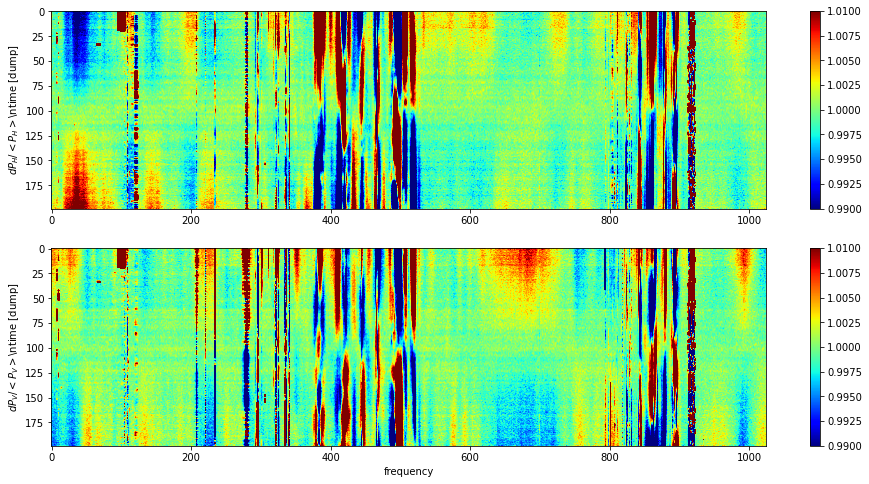

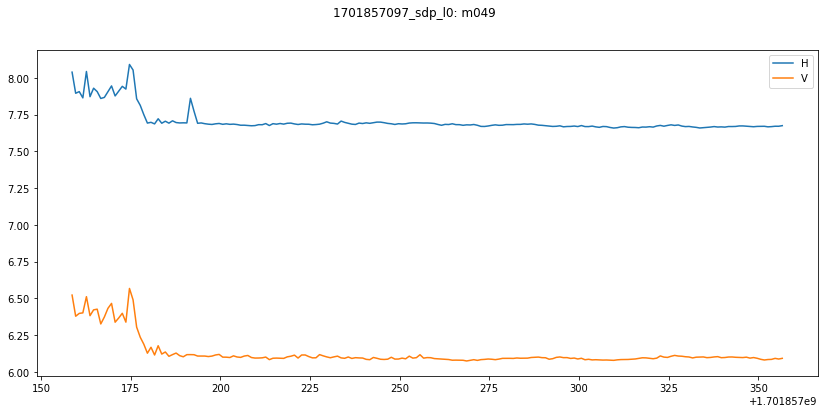

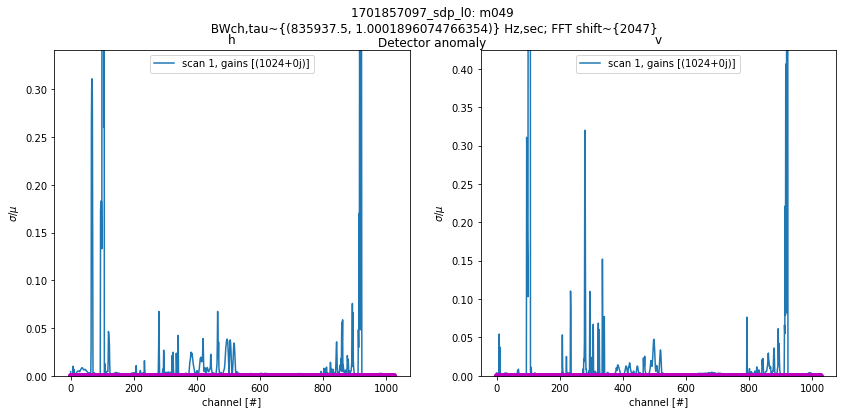

In [14]:
# Quick look at all datasets
for r in recs:
    cbid, ants = r['CaptureBlockId'], r['Antennas']
    fastgain.troubleshoot(katdal.open(dvs.cbid2url(cbid)), ants[0])

## Observation - Single Dish Pointing

More info at [DVS Operations Guide](https://docs.google.com/document/d/1mcpPv016eiNRHrLvt-Uu9z1ZOJPM4-2BknOOIALipIc) and also [MeerKAT Pointing Calibration Tutorial](https://docs.google.com/document/d/1BVpQM2ZVMHIRyjLLNlK4ecKWwXDmqVnaCdepRCbilLY/edit#heading=h.jm0yy9wwnyut).

Log on to monctl.*???*.karoo.kat.ac.za and proceed with:

    ipython
    
    import katuilib
    configure_obs()
    
    obs.sb.new(owner='DVS')
    obs.sb.proposal_id = 'DVS-TRAINING-APH'
    obs.sb.type = katuilib.ScheduleBlockTypes.OBSERVATION
    obs.sb.controlled_resources_spec = "cbf,sdp"
    obs.sb.description = 'XX-band Single Dish pointing'
    obs.sb.instruction_set = "run-obs-script /home/kat/dvs/observations/point_source_scan.py -n off -m 3600 -e --style=l /home/kat/katsdpscripts/RTS/sources_pnt_L.csv "
    obs.sb.to_defined()
    obs.sb.to_approved()
    
    obs.status()
    
This executes raster scan patterns (-e means scanning in elevation) over the targets in the catalogue for a total duration of 3600 seconds (60 mins). The --style-l scan pattern takes ~3 minutes and covers 2.6 x 2.6 degree extent in 8 slices.

Now start the observation via the GUI and follow progress on the signal displays.

In [15]:
recs = katselib.ls_archive("ProposalId:DVS-TRAINING-APH AND Description:pointing",
                          fields=['CaptureBlockId','ExperimentID','StartTime','Antennas'])

1701858025 	20231206-0019 	2023-12-06T10:20:28Z 	['m049', 'm050']


/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: War

[['PKS 2153-69', 0.32091608432910596, 0.36286716737865116],
 ['PKS 1934-63', 0.3798158525027658, 0.3996502940612501],
 ['PKS 1814-63', 1.6572435744652674, 0.8140241650436555],
 ['PKS 1610-60', 50.1365608209976, 54.4155483536238],
 ['PKS 2104-25', 0.13111948032180815, 0.20440826085438235],
 ['3C 353', 0.5576465622559682, 0.5375934580799689],
 ['Her A', 0.44179749566484355, 0.35304924402689863],
 ['Her A', 0.4259048796949867, 0.16317048868669848],
 ['3C 353', 0.11548527046630816, 0.08212512487857089]]

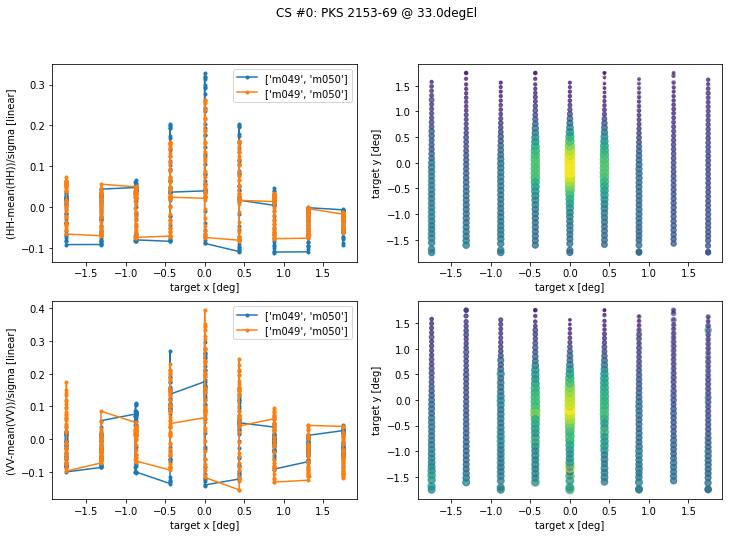

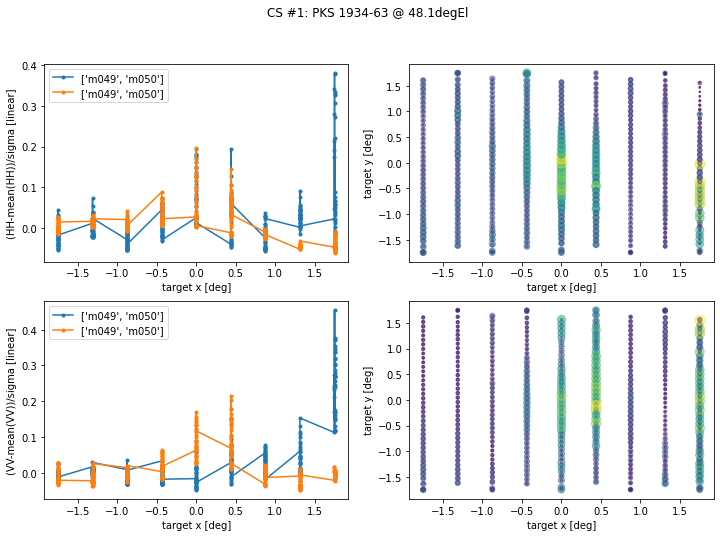

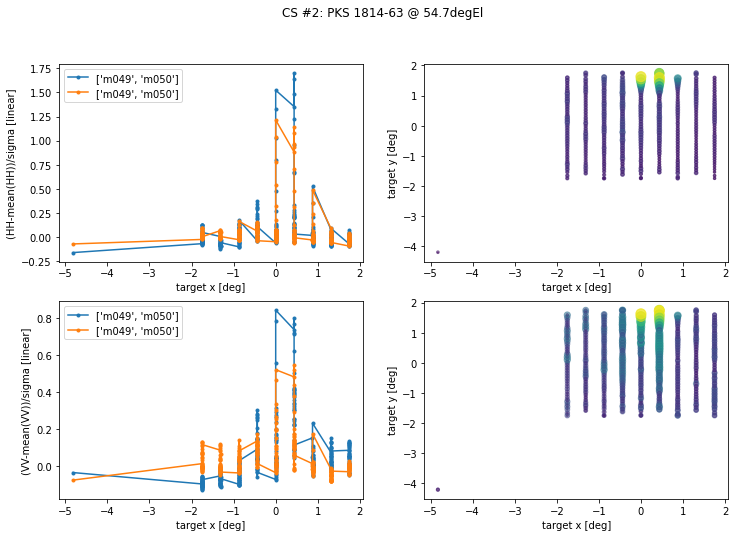

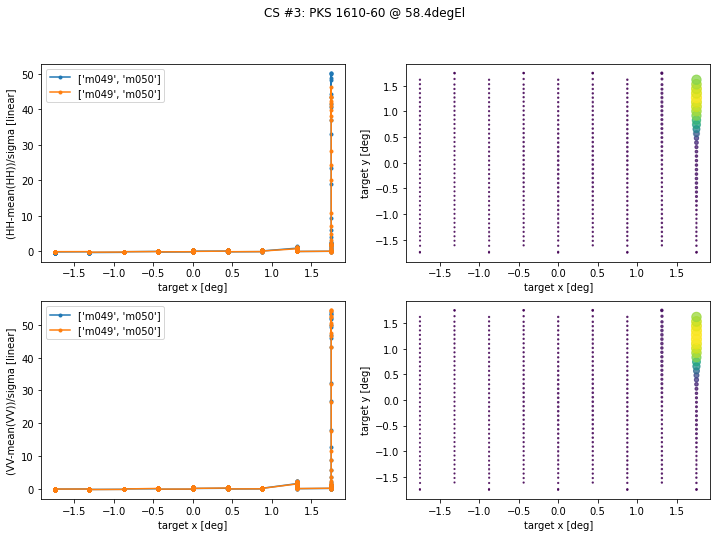

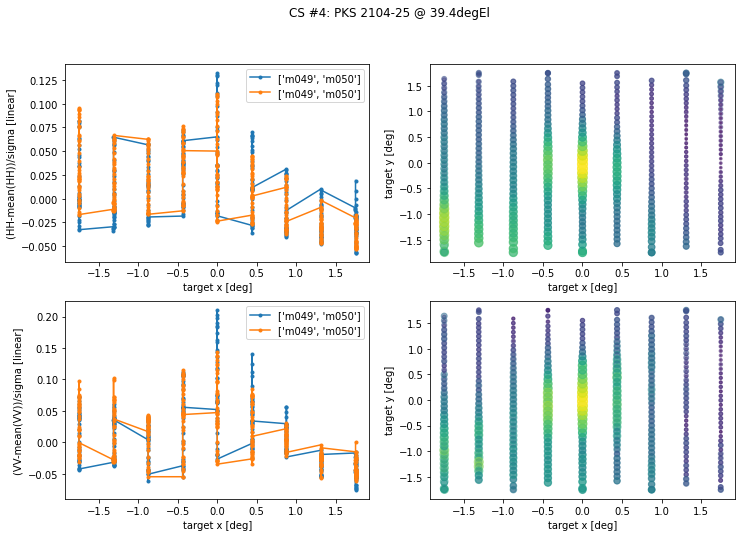

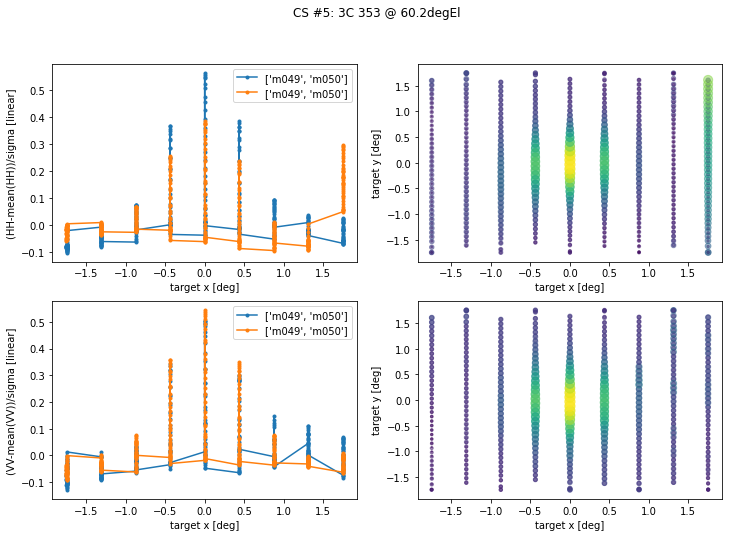

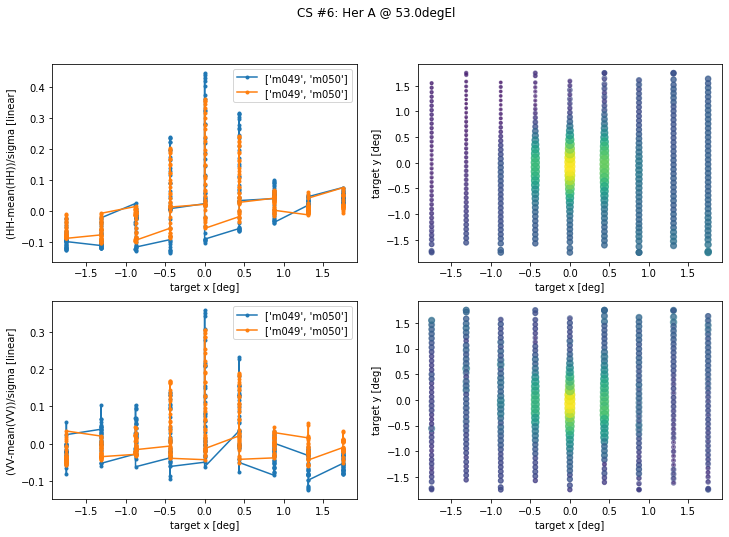

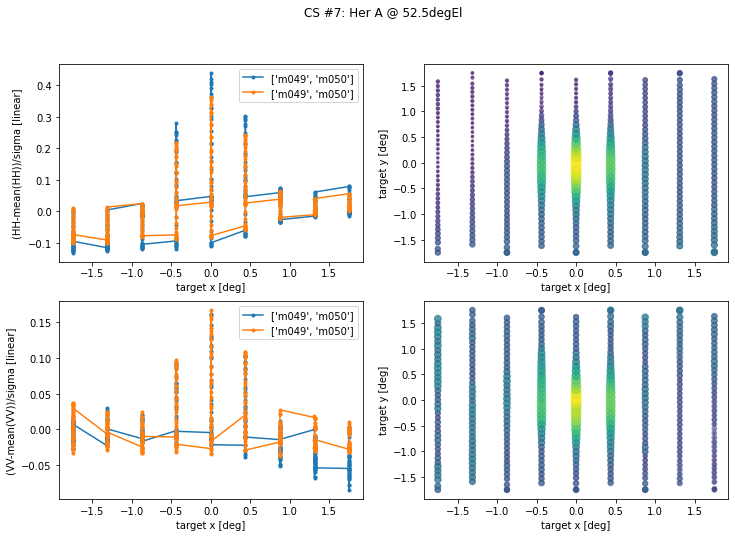

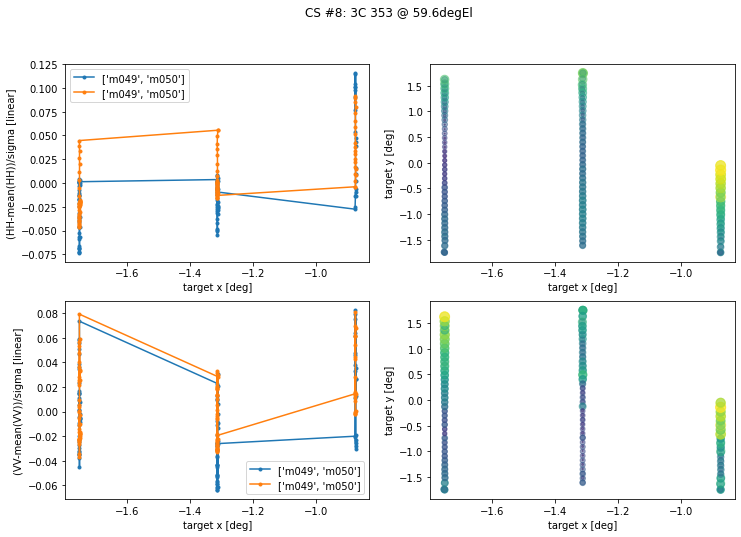

In [18]:
# Quick look at the first dataset
cbid, ants = recs[0]['CaptureBlockId'], recs[0]['Antennas']

katselib.plot_scans(katdal.open(dvs.cbid2url(cbid)), target_plane=True, ants=ants, pols=["HH","VV"])

In [20]:
# Fit centroids to the currently selected dataset
katsepnt.convert_pointingdataset(katdal.open(dvs.cbid2url(cbid)), ants='all', freq_chans="550,770", # RFI-free, see e.g fastgain.troubleshoot
                                 folder="./demo_data/pointing_results")

INFO:katsdptelstate.telescope_state:Loading 165 keys from <_io.BytesIO object at 0x7fb40f0e5eb8>
INFO:katdal.datasources:Using capture block '1701858025' and stream 'sdp_l0'
INFO:root:Loading dataset '1701858025_sdp_l0'
INFO:scape.katdal_dataset:Loading baseline 'm049,m049'
INFO:scape.katdal_dataset:Defaulting to 'coupler' noise diode (either no or both diodes are firing)


Name: 1701858025_sdp_l0 (version 4.0)
-------------------------------------------------------------------------------
URL: http://archive-gw-1.kat.ac.za/1701858025/1701858025_sdp_l0.full.rdb
Observer: DVS  Experiment ID: 20231206-0019
Description: 'DVS: L-band Single Dish pointing'
Observed from 2023-12-06 12:20:28.336 SAST to 2023-12-06 13:20:29.018 SAST
Dump rate / period: 0.99981 Hz / 1.000 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  m049,m050                            4       12
Spectral Windows: 1
  ID Band Product  CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0 L    c856M1k    1284.000         856.000           1024       835.938
-------------------------------------------------------------------------------
Data selected according to the following criteria:
  ants=['m049', 'm050']
  spw=0
  subarray=0
-------------------------------------------------------------------------------
Shape: (3600 dumps, 1024 channels, 12 corre

INFO:root:==== Processing compound scan 1 of 9: 'm049 1701858025_sdp_l0 scan 1 PKS 2153-69 2023-12-06 10:24:12.378' ====
INFO:root:==== Processing compound scan 2 of 9: 'm049 1701858025_sdp_l0 scan 19 PKS 1934-63 2023-12-06 10:31:15.458' ====
INFO:root:==== Processing compound scan 3 of 9: 'm049 1701858025_sdp_l0 scan 39 PKS 1814-63 2023-12-06 10:38:11.537' ====
INFO:root:==== Processing compound scan 4 of 9: 'm049 1701858025_sdp_l0 scan 57 PKS 1610-60 2023-12-06 10:45:16.618' ====
INFO:root:==== Processing compound scan 5 of 9: 'm049 1701858025_sdp_l0 scan 75 PKS 2104-25 2023-12-06 10:53:00.206' ====
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:==== Processing compound scan 6 of 9: 'm049 

No. of lines incl. headers 	Filename
10 		 ./pointing_results/1701858025_sdp_l0_m049_point_source_scans.csv
10 		 ./pointing_results/1701858025_sdp_l0_m050_point_source_scans.csv


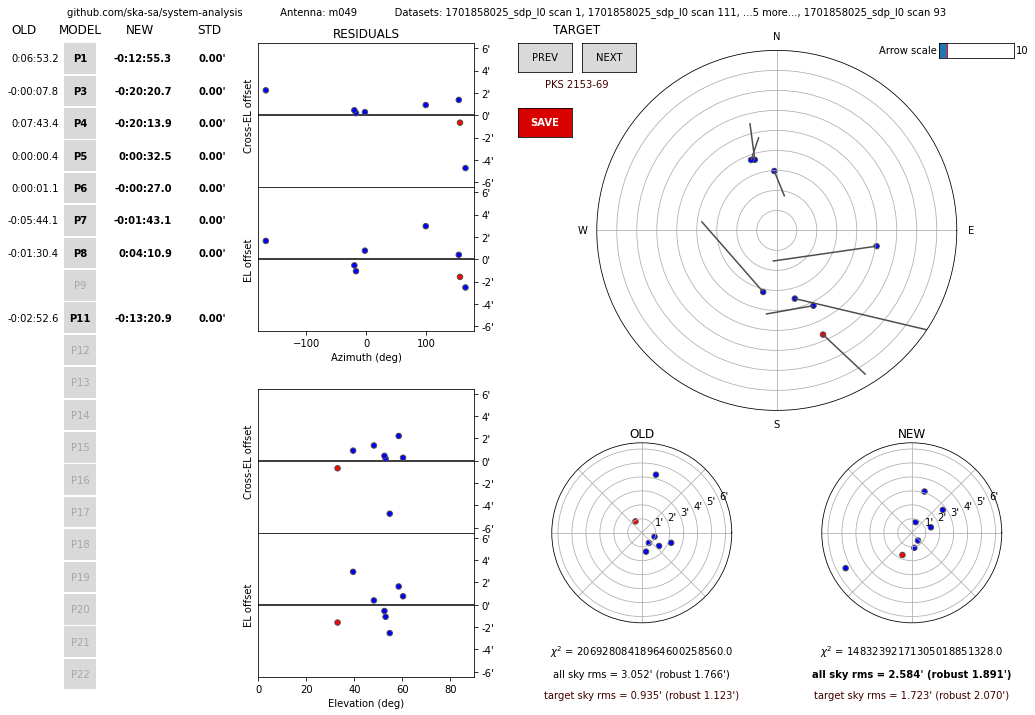

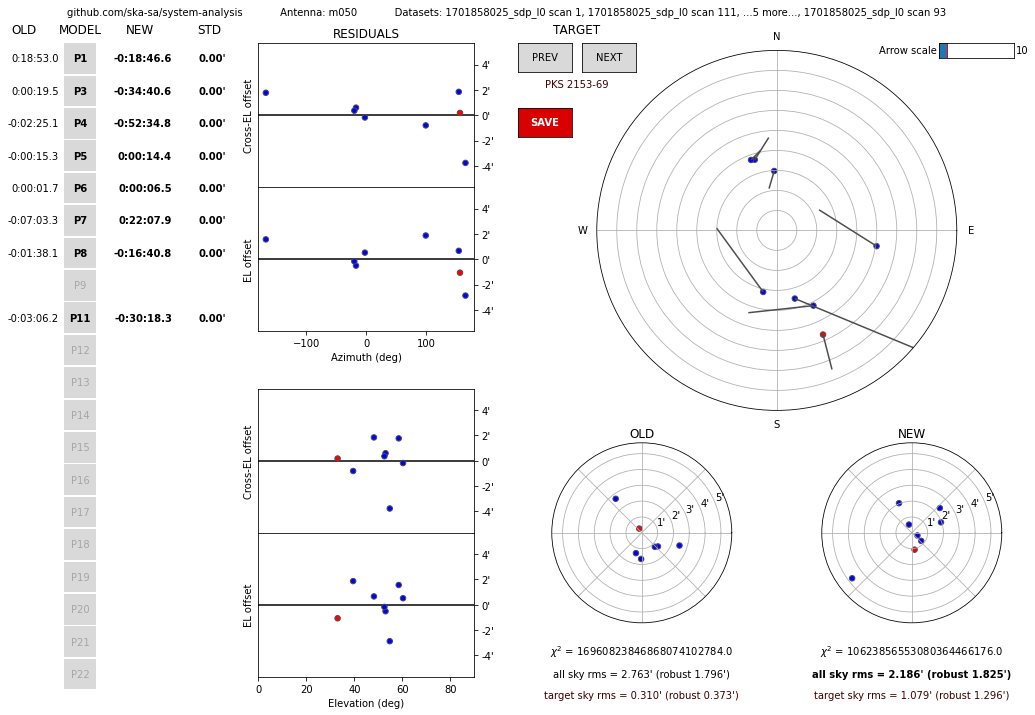

In [21]:
# Quick look at the pointing measurement set
for ant in ants:
    fit_pointing_model.fit_model(f"./demo_data/pointing_results/{cbid}_sdp_l0_{ant}_point_source_scans.csv",
                                 enabled_params=[1,3,4,5,6,7,8,11])

# Note: running fit_pointing_model.py ./demo_data/pointing_results/...csv in the command terminal makes the figures below interactive!

/home/aph/work_dvs/dvs/libraries/systems-analysis/analysis/katsepnt.py:399: RuntimeWarning: divide by zero encountered in double_scalars
  r2_adjusted = 1 - (1-r2)*(n-1)/(n-p)
/home/aph/work_dvs/dvs/libraries/systems-analysis/analysis/katsepnt.py:399: RuntimeWarning: divide by zero encountered in double_scalars
  r2_adjusted = 1 - (1-r2)*(n-1)/(n-p)


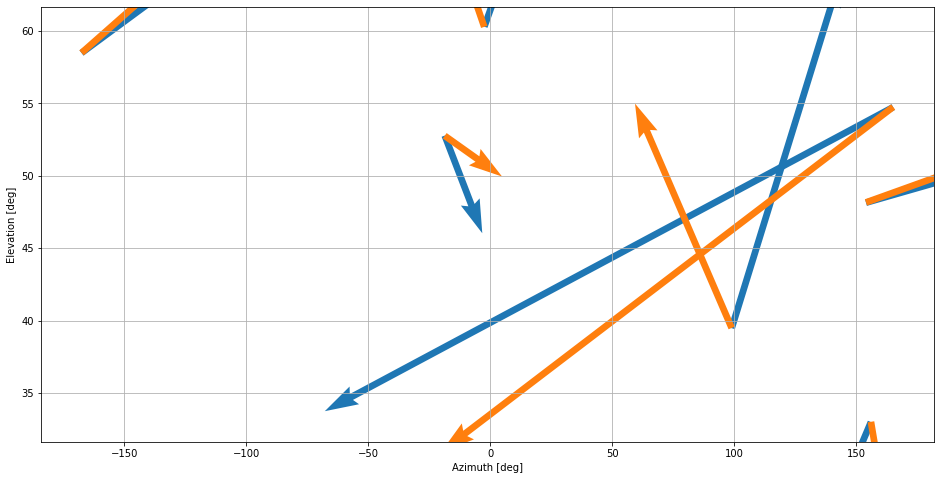

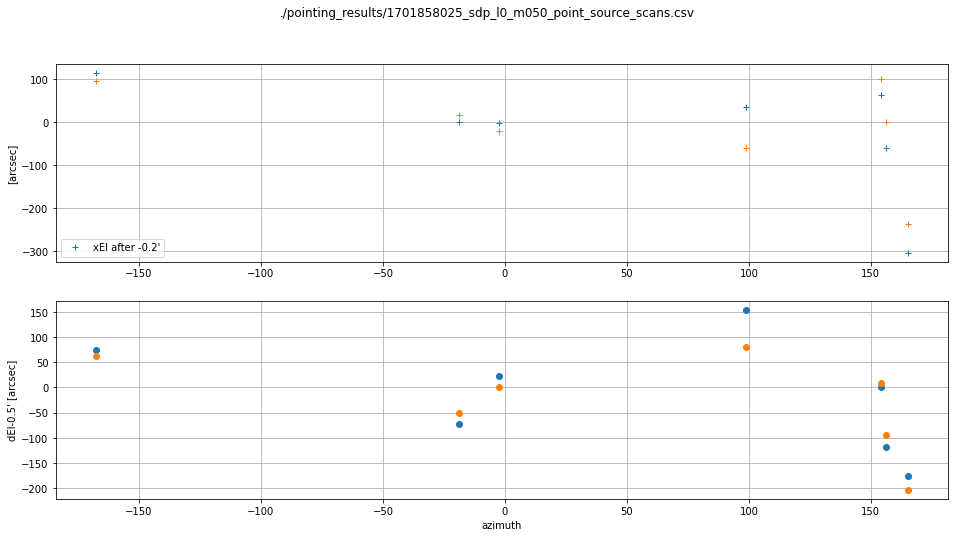

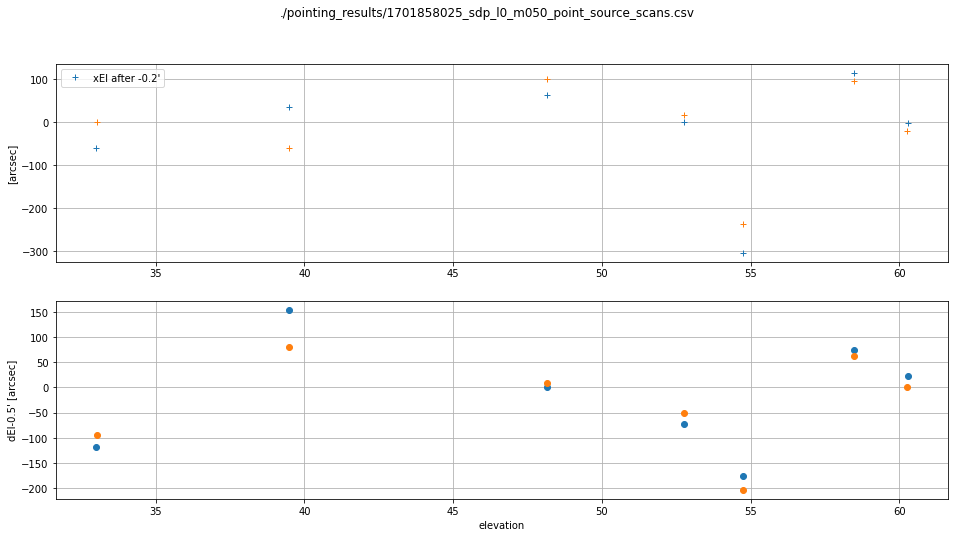

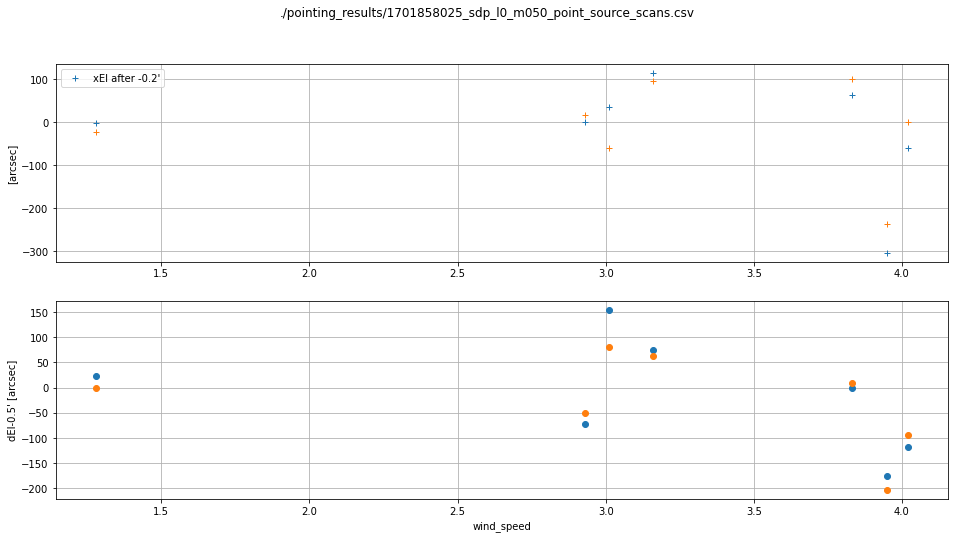

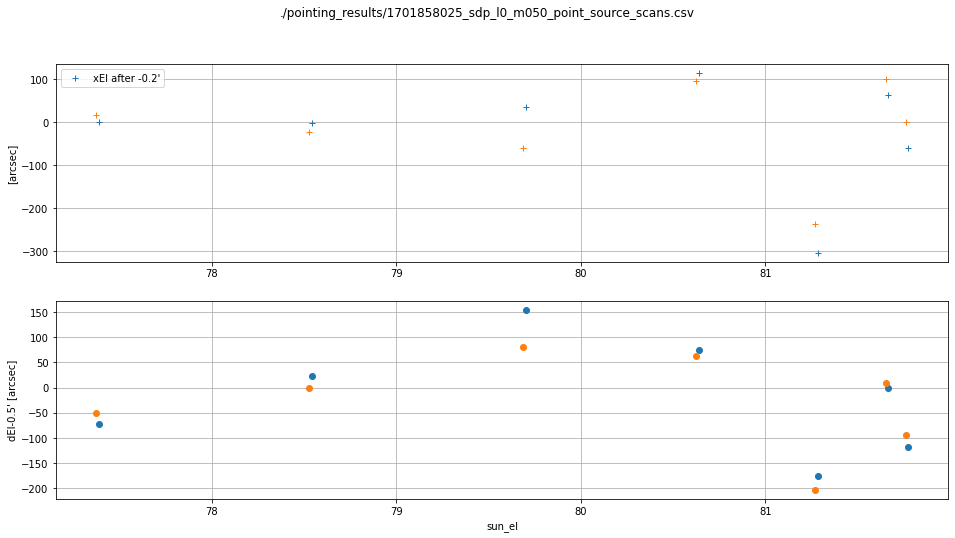

In [22]:
# Look for trends
figs = []
for ant in ants:
    katsepnt.eval_pointingstability([f"./demo_data/pointing_results/{cbid}_sdp_l0_{ant}_point_source_scans.csv"],
                                            update_model=True, Pplus=[1,3,4,5,6,7,8,11],
                                            metrics=["azimuth","elevation","wind_speed","sun_el"], figs=figs)